In [1]:
# prepend parent dir to import from local pcsp
import sys
sys.path.insert(0, '../')

In [2]:
'''Modified from sklearn documentation: https://scikit-learn.org/stable/modules/compose.html
'''
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.datasets
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, Ridge,RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score,r2_score
from sklearn.model_selection import train_test_split
import sklearn.utils
from functools import partial
import itertools
import networkx as nx
np.set_printoptions(threshold=5) # to limit printing

import pcsp
from pcsp import PCSPipeline, ModuleSet, Module, init_args, sep_dicts # must install pcsp first (pip install pcsp)
from pcsp.pipeline import build_graph

# basic pipeline

../pcsp/pipeline.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


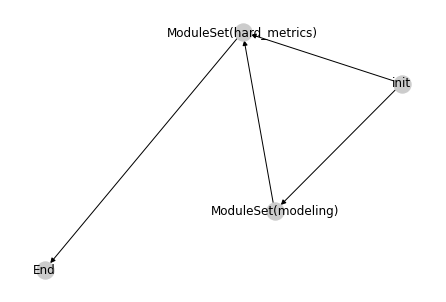

{('X_test',
  'X_train',
  'subsampling_0',
  'y_train',
  'LR',
  'y_test',
  'Acc'): 0.9230769230769231,
 ('X_test',
  'X_train',
  'subsampling_1',
  'y_train',
  'LR',
  'y_test',
  'Acc'): 0.9230769230769231,
 ('X_test',
  'X_train',
  'subsampling_2',
  'y_train',
  'LR',
  'y_test',
  'Acc'): 0.8461538461538461,
 ('X_test',
  'X_train',
  'subsampling_0',
  'y_train',
  'DT',
  'y_test',
  'Acc'): 0.7692307692307693,
 ('X_test',
  'X_train',
  'subsampling_1',
  'y_train',
  'DT',
  'y_test',
  'Acc'): 0.8461538461538461,
 ('X_test',
  'X_train',
  'subsampling_2',
  'y_train',
  'DT',
  'y_test',
  'Acc'): 0.8461538461538461,
 ('X_test',
  'X_train',
  'subsampling_0',
  'y_train',
  'LR',
  'y_test',
  'Bal_Acc'): 0.9444444444444444,
 ('X_test',
  'X_train',
  'subsampling_1',
  'y_train',
  'LR',
  'y_test',
  'Bal_Acc'): 0.9444444444444444,
 ('X_test',
  'X_train',
  'subsampling_2',
  'y_train',
  'LR',
  'y_test',
  'Bal_Acc'): 0.8375,
 ('X_test',
  'X_train',
  'subsampli

In [3]:
# initialize data
np.random.seed(13)
X, y = sklearn.datasets.make_classification(n_samples=50, n_features=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) # ex. with another split?
X_train, X_test, y_train, y_test = init_args((X_train, X_test, y_train, y_test),
                                             names=['X_train', 'X_test', 'y_train', 'y_test'])  # optionally provide names for each of these

# subsample data
subsampling_funcs = [partial(sklearn.utils.resample,
                             n_samples=20,
                             random_state=i)
                     for i in range(3)]
subsampling_set = ModuleSet(name='subsampling', modules=subsampling_funcs, output_matching=True)

X_trains, y_trains = sep_dicts(subsampling_set(X_train, y_train))

#fit models
modeling_set = ModuleSet(name='modeling',
                          modules=[LogisticRegression(max_iter=1000, tol=0.1),
                                   DecisionTreeClassifier()],
                          module_keys=["LR", "DT"])

modeling_set.fit(X_trains, y_trains)
preds_test = modeling_set.predict(X_test)

# get metrics
hard_metrics_set = ModuleSet(name='hard_metrics',
                              modules=[accuracy_score, balanced_accuracy_score],
                              module_keys=["Acc", "Bal_Acc"])

hard_metrics = hard_metrics_set.evaluate(preds_test, y_test)


 #inspect the pipeline
# for k1, v1 in hard_metrics.items():
#     print('output', k1)
G = build_graph(hard_metrics, draw=True)
plt.show()
hard_metrics

# feature engineering pipeline
**this data set predicts boston house-preices dataset (regression)**

../pcsp/pipeline.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


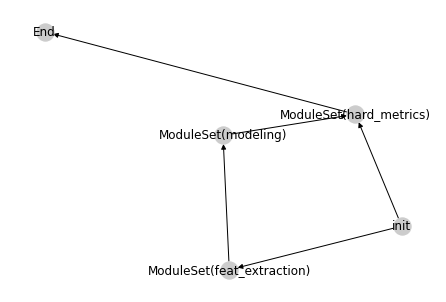

{('X_train',
  'feat_extraction_0',
  'X_train',
  'y_train',
  'DT',
  'y_train',
  'r2'): 0.998077138036731,
 ('X_train',
  'feat_extraction_1',
  'X_train',
  'y_train',
  'DT',
  'y_train',
  'r2'): 1.0,
 ('X_train',
  'feat_extraction_0',
  'X_train',
  'y_train',
  'RF',
  'y_train',
  'r2'): 0.8531972948633552,
 ('X_train',
  'feat_extraction_1',
  'X_train',
  'y_train',
  'RF',
  'y_train',
  'r2'): 0.9638279339568567,
 '__match_subkey_ids__': [1],
 '__prev__': (<pcsp.module_set.ModuleSet at 0x7f41cc492040>,)}

In [4]:
# get data as df
np.random.seed(13)
data = sklearn.datasets.load_boston()
df = pd.DataFrame.from_dict(data['data'])
df.columns = data['feature_names']
y = data['target']
X_train, X_test, y_train, y_test = init_args(train_test_split(df, y, random_state=123),
                                             names=['X_train', 'X_test', 'y_train', 'y_test'])


# feature extraction - extracts two different sets of features from the same data
def extract_feats(df: pd.DataFrame, feat_names=['CRIM', 'ZN', 'INDUS', 'CHAS']):
    '''extract specific columns from dataframe
    '''
    return df[feat_names]
feat_extraction_funcs = [partial(extract_feats, feat_names=['CRIM', 'ZN', 'INDUS', 'CHAS']),
                         partial(extract_feats, feat_names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE']),
                        ]
feat_extraction = ModuleSet(name='feat_extraction', modules=feat_extraction_funcs, output_matching=True)

X_feats_train = feat_extraction(X_train)
X_feats_test = feat_extraction(X_test)

modeling_set = ModuleSet(name='modeling',
                         modules=[DecisionTreeRegressor(), RandomForestRegressor()],
                         module_keys=["DT", "RF"])

# how can we properly pass a y here so that it will fit properly?
# this runs, but modeling_set.out is empty
_ = modeling_set.fit(X_feats_train, y_train)

# #get predictions
preds_all = modeling_set.predict(X_feats_train)

# y_test_dict = {('data_0', 'feat_extraction_0'): y_test['X_test'], ('data_0', 'feat_extraction_1'): y_test['X_test']}

#get metrics
hard_metrics_set = ModuleSet(name='hard_metrics',
                              modules=[r2_score],
                             module_keys=["r2"])
hard_metrics = hard_metrics_set.evaluate(preds_all, y_train)



# inspect the pipeline
#for k in hard_metrics:
#     print(k, hard_metrics[k])
G = build_graph(hard_metrics, draw=True)
plt.show()
hard_metrics